# Bucur Robert - Adrian
# Bogdan Gheorghe - Nicolae
## Grupa 10LF381

# Laborator 11
## Modele de clasificare text

# Setul de date SMS Spam Collection

In [1]:
import numpy as np
import pandas as pd
import string
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.util import ngrams

import matplotlib.pyplot as plt

from gensim.models import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bogdan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Incarcarea setului de date

In [2]:
sms = pd.read_csv('../data/SMS/SMSSpamCollection.txt', sep='\t', header=None)

sms.head()

,0,1
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Statistica

# Eliminarea stopwords si afisarea numarului de aparitii a ficarui cuvant

In [3]:
countVectorizer = CountVectorizer(stop_words=stopwords.words('english'))
countVectorizer.fit(sms.loc[:, 1])
words_frequency = dict(countVectorizer.vocabulary_.items())
sms[1] = [text.replace('〨ud', '') for text in sms[1]]
sms[1] = [text.replace('ú1', '') for text in sms[1]]

pd.DataFrame(np.matrix(list(countVectorizer.vocabulary_.items())), columns=['word', 'frequency'])

,word,frequency
0,go,3533
1,jurong,4310
2,point,5870
3,crazy,2314
4,available,1303
...,...,...
8570,087187272008,165
8571,now1,5378
8572,pity,5801
8573,suggestions,7324


# Afisam numarul de sms-uri acceptate si lungimile cuvintelor: minim, maxim, mediu

Total accepted sms: 4825
Total spam sms: 747
Min word length: 1
Max word length: 171
Mean word length: 15
The most frequent word: [('〨ud', 8574)]


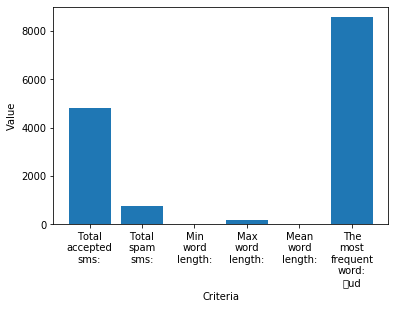

In [4]:
total_accepted_sms = len(sms[sms[0]==0])
print('Total accepted sms:', total_accepted_sms)
total_spam_sms = len(sms[sms[0]==1])
print('Total spam sms:', total_spam_sms)

word_length_data = sms.loc[:, 1].apply(lambda x: len(x.split()))
print('Min word length:', word_length_data.min())
print('Max word length:', word_length_data.max())
print('Mean word length:', int((word_length_data.mean())))

most_frequent_word = [(key, value)  for (key, value) in words_frequency.items() if value == max(words_frequency.values())]
print('The most frequent word:', most_frequent_word)

x = np.array(['Total\naccepted\nsms:', 'Total\nspam\nsms:', 'Min\nword\nlength:', 'Max\nword\nlength:', 'Mean\nword\nlength:', 'The\nmost\nfrequent\nword:\n' + most_frequent_word[0][0]])
y = np.array([total_accepted_sms, total_spam_sms, word_length_data.min(), word_length_data.max(), int((word_length_data.mean())), most_frequent_word[0][1]])
plt.bar(x, y)
plt.xlabel('Criteria')
plt.ylabel('Value')
plt.show()

# Afisarea fiecarui sms cu numarul de cuvinte

In [5]:
words_number = sms.loc[:, 1].apply(lambda x:len(str(x).split(' ')))

pd.DataFrame(np.matrix(list(zip(sms[1], words_number))), columns=['text', 'no_words'])

,text,no_words
0,"Go until jurong point, crazy.. Available only ...",20
1,Ok lar... Joking wif u oni...,6
2,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,U dun say so early hor... U c already then say...,11
4,"Nah I don't think he goes to usf, he lives aro...",13
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,30
5568,Will ü b going to esplanade fr home?,8
5569,"Pity, * was in mood for that. So...any other s...",10
5570,The guy did some bitching but I acted like i'd...,26


# Preprocesare

## Am convertit la litere mici

In [6]:
sms[1] = sms[1].apply(lambda x: x.lower())
sms[1]

0       go until jurong point, crazy.. available only ...
1                           ok lar... joking wif u oni...
2       free entry in 2 a wkly comp to win fa cup fina...
3       u dun say so early hor... u c already then say...
4       nah i don't think he goes to usf, he lives aro...
                              ...                        
5567    this is the 2nd time we have tried 2 contact u...
5568                 will ü b going to esplanade fr home?
5569    pity, * was in mood for that. so...any other s...
5570    the guy did some bitching but i acted like i'd...
5571                           rofl. its true to its name
Name: 1, Length: 5572, dtype: object

## Am eliminat cifrele/numerele

In [7]:
sms[1] = sms[1].apply(lambda x: re.sub(r'\d+', ' ', x))
sms[1]


0       go until jurong point, crazy.. available only ...
1                           ok lar... joking wif u oni...
2       free entry in   a wkly comp to win fa cup fina...
3       u dun say so early hor... u c already then say...
4       nah i don't think he goes to usf, he lives aro...
                              ...                        
5567    this is the  nd time we have tried   contact u...
5568                 will ü b going to esplanade fr home?
5569    pity, * was in mood for that. so...any other s...
5570    the guy did some bitching but i acted like i'd...
5571                           rofl. its true to its name
Name: 1, Length: 5572, dtype: object

## Am eliminat semnele de punctuatie

In [8]:
sms[1] = sms[1].apply(lambda x: re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\]ˆ_`{|}~]', '', x))
sms[1]

0       go until jurong point crazy available only in ...
1                                 ok lar joking wif u oni
2       free entry in   a wkly comp to win fa cup fina...
3             u dun say so early hor u c already then say
4       nah i dont think he goes to usf he lives aroun...
                              ...                        
5567    this is the  nd time we have tried   contact u...
5568                  will ü b going to esplanade fr home
5569    pity  was in mood for that soany other suggest...
5570    the guy did some bitching but i acted like id ...
5571                            rofl its true to its name
Name: 1, Length: 5572, dtype: object

## Am eliminat spatiile albe (mai exact tab-urile \t)

In [9]:
sms[1] = sms[1].apply(lambda x: x.strip())
sms[1]

0       go until jurong point crazy available only in ...
1                                 ok lar joking wif u oni
2       free entry in   a wkly comp to win fa cup fina...
3             u dun say so early hor u c already then say
4       nah i dont think he goes to usf he lives aroun...
                              ...                        
5567    this is the  nd time we have tried   contact u...
5568                  will ü b going to esplanade fr home
5569    pity  was in mood for that soany other suggest...
5570    the guy did some bitching but i acted like id ...
5571                            rofl its true to its name
Name: 1, Length: 5572, dtype: object

## Am eliminat spatiile duble

In [10]:
sms[1] = sms[1].apply(lambda x: re.sub(r'\s{2,}', ' ', x))
sms[1]

0       go until jurong point crazy available only in ...
1                                 ok lar joking wif u oni
2       free entry in a wkly comp to win fa cup final ...
3             u dun say so early hor u c already then say
4       nah i dont think he goes to usf he lives aroun...
                              ...                        
5567    this is the nd time we have tried contact u u ...
5568                  will ü b going to esplanade fr home
5569    pity was in mood for that soany other suggestions
5570    the guy did some bitching but i acted like id ...
5571                            rofl its true to its name
Name: 1, Length: 5572, dtype: object

## Am transformat cuvintele derivate in cuvinte radacina

In [11]:
stemmer= PorterStemmer()
sms[1] = sms[1].apply(lambda x: stemmer.stem(x))
sms[1]

0       go until jurong point crazy available only in ...
1                                 ok lar joking wif u oni
2       free entry in a wkly comp to win fa cup final ...
3             u dun say so early hor u c already then say
4       nah i dont think he goes to usf he lives aroun...
                              ...                        
5567    this is the nd time we have tried contact u u ...
5568                   will ü b going to esplanade fr hom
5569        pity was in mood for that soany other suggest
5570    the guy did some bitching but i acted like id ...
5571                             rofl its true to its nam
Name: 1, Length: 5572, dtype: object

# Codificare BoW

In [12]:
bow = CountVectorizer(analyzer="word")
X = bow.fit_transform(sms.iloc[:, 1])
y = sms.iloc[:, 0]

# Clasificare

In [13]:
sms_df = pd.DataFrame()

In [14]:
parameters_dtc = {'splitter': ['best', 'random'], 'max_depth': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
parameters_knn = {'n_neighbors': list(range(1, 10)), 'p': [1, 2, 3, 4.7]}
parameters_svc = {'gamma': ['auto', 'scale'], 'C': list(range(1, 10))}
parameters_rfc = {'max_depth': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

## Primul model de clasificare: DecisionTreeClassifier

In [15]:
grid_search_dtc = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parameters_dtc, scoring='f1', cv=3)
grid_scores_dtc = cross_validate(estimator=grid_search_dtc, scoring=('accuracy', 'f1'), X=X, y=y, cv=5, return_train_score=True)

df_grid_sms = pd.DataFrame(grid_scores_dtc)
df_grid_sms = df_grid_sms.mean()
df_grid_sms['Model_name'] = 'DecisionTreeClassifier'
df_grid_sms['Search_strategy'] = 'GridSearch'

df_grid_sms = pd.Series(df_grid_sms)
sms_df = sms_df.append(df_grid_sms, ignore_index=True)

In [16]:
randomized_search_dtc = RandomizedSearchCV(estimator=DecisionTreeClassifier(), param_distributions=parameters_dtc, random_state=0, scoring='f1', cv=3, n_iter=5)
randomized_scores_dtc = cross_validate(estimator=randomized_search_dtc, scoring=('accuracy', 'f1'), X=X, y=y, cv=5, return_train_score=True)

df_randomized_sms = pd.DataFrame(randomized_scores_dtc)
df_randomized_sms = df_randomized_sms.mean()
df_randomized_sms['Model_name'] = 'DecisionTreeClassifier'
df_randomized_sms['Search_strategy'] = 'RandomizedSearch'

df_randomized_sms = pd.Series(df_randomized_sms)
sms_df = sms_df.append(df_randomized_sms, ignore_index=True)

## Al doilea model de clasificare: KNeighborsClassifier

In [17]:
grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parameters_knn, scoring='f1', cv=3)
grid_scores_knn = cross_validate(estimator=grid_search_knn, scoring=('accuracy', 'f1'), X=X, y=y, cv=5, return_train_score=True)

df_grid_sms = pd.DataFrame(grid_scores_knn)
df_grid_sms = df_grid_sms.mean()
df_grid_sms['Model_name'] = 'KNeighborsClassifier'
df_grid_sms['Search_strategy'] = 'GridSearch'

df_grid_sms = pd.Series(df_grid_sms)
sms_df = sms_df.append(df_grid_sms, ignore_index=True)

In [18]:
randomized_search_knn = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions=parameters_knn, random_state=0, scoring='f1', cv=3, n_iter=5)
randomized_scores_knn = cross_validate(estimator=randomized_search_knn, scoring=('accuracy', 'f1'), X=X, y=y, cv=5, return_train_score=True)

df_randomized_sms = pd.DataFrame(randomized_scores_knn)
df_randomized_sms = df_randomized_sms.mean()
df_randomized_sms['Model_name'] = 'KNeighborsClassifier'
df_randomized_sms['Search_strategy'] = 'RandomizedSearch'

df_randomized_sms = pd.Series(df_randomized_sms)
sms_df = sms_df.append(df_randomized_sms, ignore_index=True)

## Al treilea model de clasificare: SVM.SVC

In [19]:
grid_search_svc = GridSearchCV(estimator=SVC(), param_grid=parameters_svc, scoring='f1', cv=3)
grid_scores_svc = cross_validate(estimator=grid_search_svc, scoring=('accuracy', 'f1'), X=X, y=y, cv=5, return_train_score=True)

df_grid_sms = pd.DataFrame(grid_scores_svc)
df_grid_sms = df_grid_sms.mean()
df_grid_sms['Model_name'] = 'SVC'
df_grid_sms['Search_strategy'] = 'GridSearch'

df_grid_sms = pd.Series(df_grid_sms)
sms_df = sms_df.append(df_grid_sms, ignore_index=True)

In [20]:
randomized_search_svc = RandomizedSearchCV(estimator=SVC(), param_distributions=parameters_svc, random_state=0, scoring='f1', cv=3, n_iter=5)
randomized_scores_svc = cross_validate(estimator=randomized_search_svc, scoring=('accuracy', 'f1'), X=X, y=y, cv=5, return_train_score=True)

df_randomized_sms = pd.DataFrame(randomized_scores_svc)
df_randomized_sms = df_randomized_sms.mean()
df_randomized_sms['Model_name'] = 'SVC'
df_randomized_sms['Search_strategy'] = 'RandomizedSearch'

df_randomized_sms = pd.Series(df_randomized_sms)
sms_df = sms_df.append(df_randomized_sms, ignore_index=True)

## Al patrulea model de clasificare: RandomForestClassifier

In [21]:
grid_search_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters_rfc, scoring='f1', cv=3)
grid_scores_rfc = cross_validate(estimator=grid_search_rfc, scoring=('accuracy', 'f1'), X=X, y=y, cv=5, return_train_score=True)

df_grid_sms = pd.DataFrame(grid_scores_rfc)
df_grid_sms = df_grid_sms.mean()
df_grid_sms['Model_name'] = 'RandomForestClassifier'
df_grid_sms['Search_strategy'] = 'GridSearch'

df_grid_sms = pd.Series(df_grid_sms)
sms_df = sms_df.append(df_grid_sms, ignore_index=True)

In [22]:
randomized_search_rfc = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=parameters_rfc, random_state=0, scoring='f1', cv=3, n_iter=5)
randomized_scores_rfc = cross_validate(estimator=randomized_search_rfc, scoring=('accuracy', 'f1'), X=X, y=y, cv=5, return_train_score=True)

df_randomized_sms = pd.DataFrame(randomized_scores_rfc)
df_randomized_sms = df_randomized_sms.mean()
df_randomized_sms['Model_name'] = 'RandomForestClassifier'
df_randomized_sms['Search_strategy'] = 'RandomizedSearch'

df_randomized_sms = pd.Series(df_randomized_sms)
sms_df = sms_df.append(df_randomized_sms, ignore_index=True)

# Raportul final

In [24]:
sms_df

,Model_name,Search_strategy,fit_time,score_time,test_accuracy,test_f1,train_accuracy,train_f1
0,DecisionTreeClassifier,GridSearch,0.619141,0.003513,0.879757,0.405432,0.884243,0.448013
1,DecisionTreeClassifier,RandomizedSearch,0.375353,0.003196,0.879218,0.394608,0.881685,0.415575
2,KNeighborsClassifier,GridSearch,17.080231,0.244479,0.950107,0.775309,1.000000,1.000000
3,KNeighborsClassifier,RandomizedSearch,2.160306,0.378514,0.919778,0.573848,0.933462,0.669939
4,SVC,GridSearch,47.792582,0.323490,0.976131,0.902440,0.999192,0.996978
5,SVC,RandomizedSearch,14.366491,0.332816,0.973439,0.890467,0.994661,0.979682
6,RandomForestClassifier,GridSearch,7.797618,0.025346,0.865937,0.000000,0.865937,0.000000
7,RandomForestClassifier,RandomizedSearch,4.758844,0.034509,0.865937,0.000000,0.865937,0.000000


In [25]:
sms_df.style.highlight_max(color='red').highlight_min(color='green')

,Model_name,Search_strategy,fit_time,score_time,test_accuracy,test_f1,train_accuracy,train_f1
0,DecisionTreeClassifier,GridSearch,0.619141,0.003513,0.879757,0.405432,0.884243,0.448013
1,DecisionTreeClassifier,RandomizedSearch,0.375353,0.003196,0.879218,0.394608,0.881685,0.415575
2,KNeighborsClassifier,GridSearch,17.080231,0.244479,0.950107,0.775309,1.000000,1.000000
3,KNeighborsClassifier,RandomizedSearch,2.160306,0.378514,0.919778,0.573848,0.933462,0.669939
4,SVC,GridSearch,47.792582,0.323490,0.976131,0.902440,0.999192,0.996978
5,SVC,RandomizedSearch,14.366491,0.332816,0.973439,0.890467,0.994661,0.979682
6,RandomForestClassifier,GridSearch,7.797618,0.025346,0.865937,0.000000,0.865937,0.000000
7,RandomForestClassifier,RandomizedSearch,4.758844,0.034509,0.865937,0.000000,0.865937,0.000000


## Randarea fisierului html

In [26]:
sms_html = sms_df.style.highlight_max(color='red').highlight_min(color='green').render()

text_file = open('../html_files/sms.html', 'w')
text_file.write('<br>')
text_file.write('<h1><center> Dataset: SMS Spam Collection <center></h1>')
text_file.write('<br><br><br><br><br><br><br><center>')
text_file.write(sms_html)
text_file.write('</center>')
text_file.close()